In [1]:
import json
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers import pipeline
import torch
from qdrant_client import QdrantClient
from qdrant_client.http import models as qdrant_models
import pandas as pd

MODEL_NAME = "intfloat/e5-small-v2"
QDRANT_HOST = "localhost"
QDRANT_PORT = 6333
COLLECTION_NAME = "pmc_e5_full_docs"
EMBED_DIM = 384

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.eval()
if torch.cuda.is_available():
    model.cuda()

In [2]:
def get_embedding(text):
    inp = f"passage: {text.strip()}"
    encoded = tokenizer(inp, return_tensors="pt", truncation=True, max_length=512)
    if torch.cuda.is_available():
        encoded = {k: v.cuda() for k, v in encoded.items()}
    with torch.no_grad():
        out = model(**encoded)
    return out.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# --- 3. Connect to Qdrant ---
client = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)
print("Qdrant connection ok")

Qdrant connection ok


In [4]:
df = pd.read_json("../../data/parsed_pmc_2_1000.jsonl", lines=True)
df["text"] = df["title"] + " " + df["abstract"]

sample_texts = df["text"].dropna().tolist()[:500]

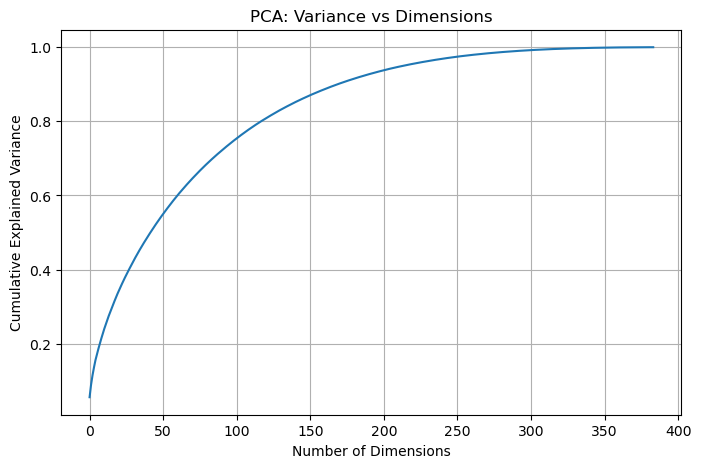

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

embeddings = np.array([get_embedding(text) for text in sample_texts])
pca = PCA()
pca.fit(embeddings)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance)
plt.xlabel("Number of Dimensions")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Variance vs Dimensions")
plt.grid(True)
plt.show()
